In [27]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import os
import statistics as pystats

# Get All of the fits Files Associated with a Given Galaxy

In [28]:
import glob
import fnmatch
import pandas as pd

dir = '/Users/michaelhill/Downloads/' # directory containing folders containing galaxy fits files
galaxy = 'ngc0628' # name of folder to look in (I actually have all my galaxy files in same folder, see his original for how to do it that way)

def sort_by_wavelength(instruments): # works for wise and irac; obviously still works even if you're only using a subset of instruments
    wavelengths = {'w1': 3.4,
                   'w2': 4.6,
                   'w3': 12,
                   'w4': 22,
                   'irac1': 3.6,
                   'irac2': 4.5,
                   'irac3': 5.8,
                   'irac4': 8,
                   'mips24': 24,
                   'f200w': 1.990,
                   'f300m': 2.996,
                   'f335m': 3.365,
                   'f360m': 3.621,
                   'f770w': 7.7,
                   'f1000w': 10.0,
                   'f1130w': 11.3,
                   'f2100w': 21.0}
    sorted_wavelengths = dict(sorted(wavelengths.items(), key=lambda x:x[1])) # maybe I should just modify wavelengths dict to already be sorted
    result = []
    for k,_ in sorted_wavelengths.items():
        for instr in instruments:
            if k == instr:
                result.append(instr)
    return result
    

def galx_ser_irac_wise(galaxy, dir): # for irac and wise
    # get all filenames for ngc0628 (irac and wise)
    folder = dir + 'raw_background_comps/'
    galx_names = glob.glob(galaxy + '*.fits', root_dir=folder)
    
    galx_instruments = []
    for galx in galx_names:
        components = galx.split('_')
        for component in components:
            if fnmatch.fnmatchcase(component, 'w?') or fnmatch.fnmatchcase(component, 'irac?'): # the ? is a stand-in for a single character # should I include gauss for irac?
                galx_instruments.append(component)

    # open all these galaxies with the appropriate names
    galx_hdu = []
    for galx in galx_names:
        galx_hdu.append(fits.open(folder + galx)[0])

    galx_ser = pd.Series(galx_hdu, index=galx_instruments)
    
    return galx_ser, galx_instruments

def galx_ser_jwst(galaxy, dir):
    # get all filenames for ngc0628 (irac and wise)
    folder = dir + 'hlsp_phangs-jwst_jwst_miri-nircam_' + galaxy + '_multi_v1p1_img/'
    galx_names = os.listdir(folder)
    
    galx_instruments = []
    for galx in galx_names:
        components = galx.split('_')
        for component in components:
            if fnmatch.fnmatchcase(component, 'f*'): # should I include nircam vs miri?
                galx_instruments.append(component)

    # open all these galaxies with the appropriate names
    galx_hdu = []
    for galx in galx_names:
        galx_hdu.append(fits.open(folder + galx)[1])

    # mask out the zeroes (i should find a better way to do this (masks out part of galaxy))
    for hdu in galx_hdu:
        mask = hdu.data == 0
        hdu.data[mask] = np.nan
    
    galx_ser = pd.Series(galx_hdu, index=galx_instruments)
    
    return galx_ser, galx_instruments

def galx_ser_irac_wise_jwst(galaxy, dir):
    ser1, instr1 = galx_ser_irac_wise(galaxy, dir)
    ser2, instr2 = galx_ser_jwst(galaxy, dir)
    
    combined_index = [index for index in ser1.index]
    combined_index.extend([index for index in ser2.index])
    
    combined_data = ser1.values.tolist()
    combined_data.extend(ser2.values.tolist())
    
    galx_ser = pd.Series(combined_data, index=combined_index)
    
    instr1.extend(instr2)
    galx_instruments = instr1

    return galx_ser, galx_instruments

galx_ser, galx_instruments = galx_ser_irac_wise(galaxy, dir)
# galx_ser, galx_instruments = galx_ser_jwst(galaxy, dir)
# galx_ser, galx_instruments = galx_ser_irac_wise_jwst(galaxy, dir)
### which function you call to initialize galx_ser and galx_instruments determines which filters will be used in creating all subsequent plots ###

galx_instruments = sort_by_wavelength(galx_instruments)
# galx_instruments.sort() # to sort alphabetically instead
print(galx_instruments)


# note: can't sort anything prior to making galx_series or else the labels will be mismatched with the HDUs
# note: the reason mips24 is not included is that I'm using raw_background_comps folder, those are only in the background_comps folder

['w1', 'irac1', 'irac2', 'w2', 'irac3', 'irac4', 'w3', 'w4']


# Decide Which Plot-Types to Generate

In [29]:
histograms = True
statistics = False
radial_profiles = True
scatter_plots = True
histograms_2d = True

# you may want to set statistics to false since they take forever to generate (unless you're interested in them); you also may want to generate both scatter_plots and 2d-histograms since they offer the same insight

# Autogenerate Histograms of the Particular Galaxy
Based off of Jackson's Autohistogram

In [30]:
# vars to edit
saveFigs = False
saveStats = False # save histograms stats like mean, median, mode
saveDir = '/Users/michaelhill/Desktop/PHANGS/' + galaxy + '_auto'
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'purple'] # this is the order that they will be used; if there are more than 8 plots to be generated, I must modify code
minclip, maxclip, bincount = -.1, .1, 1000 # I tend to use -.1, .1 for irac/wise and -1, 5 for JWST
bins=np.linspace(minclip, maxclip, bincount) # all figures use same bin count, setting it here to be constant
figx = 6 # apparently, figsize is given inches, whatever that means
figy = 6
xlabel = 'Intensity (MJy/sr)'
ylabel = 'Frequency' # of those values


# make directory to store figs if it doesn't exist
if (saveFigs or saveStats):
    if (not os.path.isdir(saveDir + '/figs/')):
        os.mkdir(saveDir + '/figs/')

# open/create text file to store histogram statistics
if (saveStats == True):
    statsFile = open(saveDir + '/figs/stats.txt', 'a') # I'm pretty sure previous line is useless because if files doesn't exist, 'a' means it will be created (which is what 'x' does)
        
# # function to save figs
# def saveFig(instr):
#     plt.savefig(saveDir + '/figs/' + instr + '.png')   
       
# function to calculate mean, median, mode and print to file
def calcMMM(data, instr): ####### I think this could just have one argument since instr is wdata converted to string?
    mean = pystats.mean(data)
    meanString = "\nMean of " + instr + ": " + str(mean)
    print(meanString)
    median = pystats.median(data)
    medianString = "\nMedian of " + instr + ": " + str(median)
    print(medianString)
    # mode = pystats.mode(data)
    # modeString = "\nMode of " + instr + ": " + str(mode)
    # print(modeString)
    # if (saveStats == True):
    #     statsFile.write(meanString)
    #     statsFile.write(medianString)
    #     statsFile.write(modeString)
    #     statsFile.write('\n')

def create_hist(instr, figx, figy, xlabel, ylabel, bins, color):
    f = plt.figure(figsize=(figx, figy))
    Y, BE = np.histogram(galx_ser[instr].data, bins=bins) # returns frequencies of each intensity to Y, each intensity to BE (but BE has length bincount and Y has length bincount-1, I guess because BE includes endpoint but Y is associating frequency with the starting intensity for each interval, so nothing associated with endpoint intensity for Y)
    X = BE[:-1] # need to remove last row to have X and Y be equal lengths
    plt.plot(X, Y, color=color)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(instr)
    plt.ylim(bottom=0)
    # if (saveFigs == True):
    #     saveFig(instr)

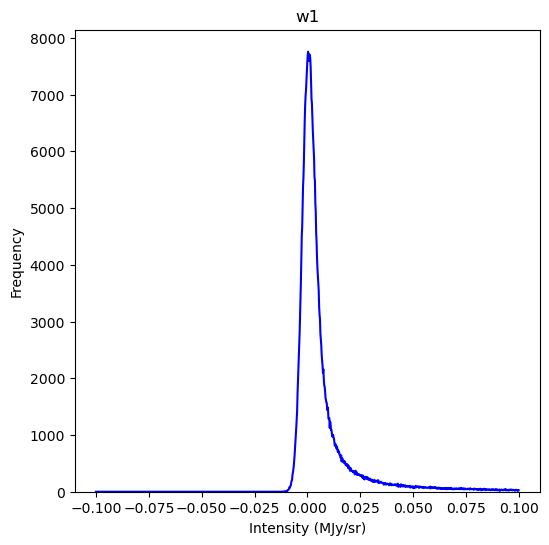

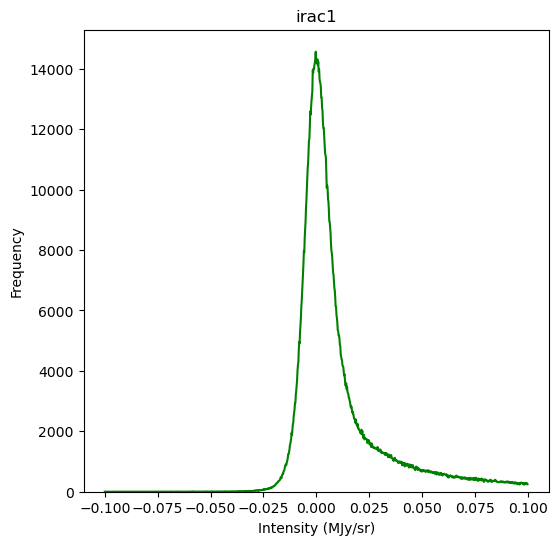

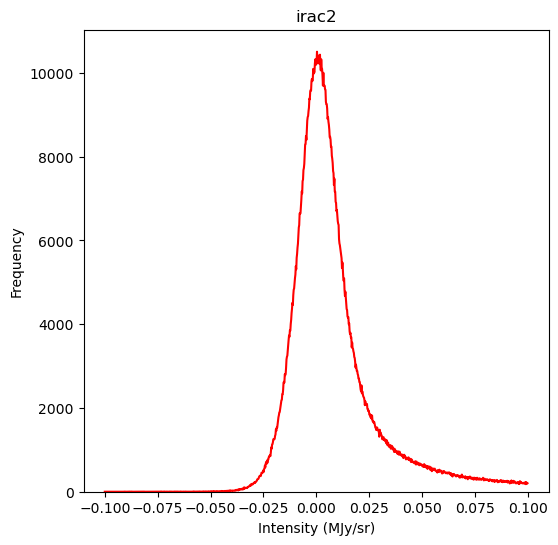

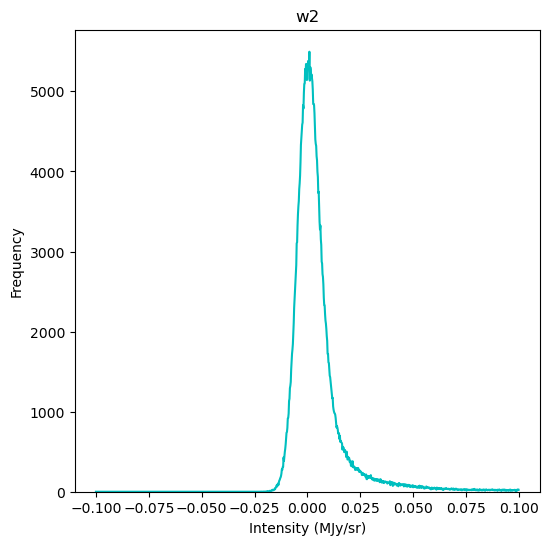

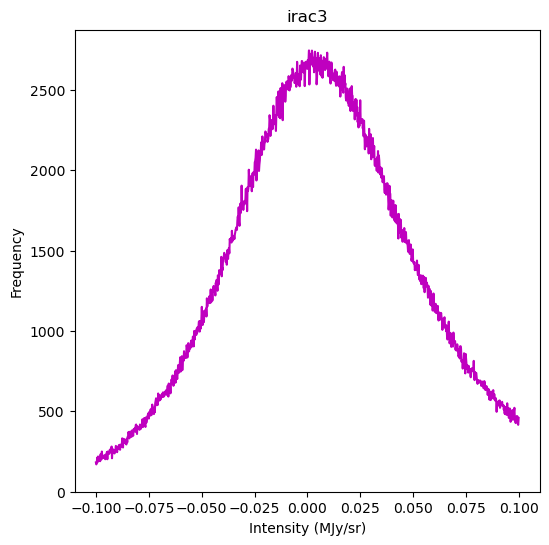

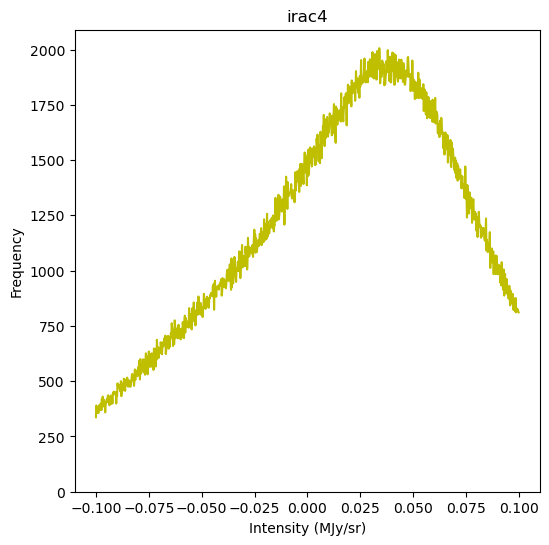

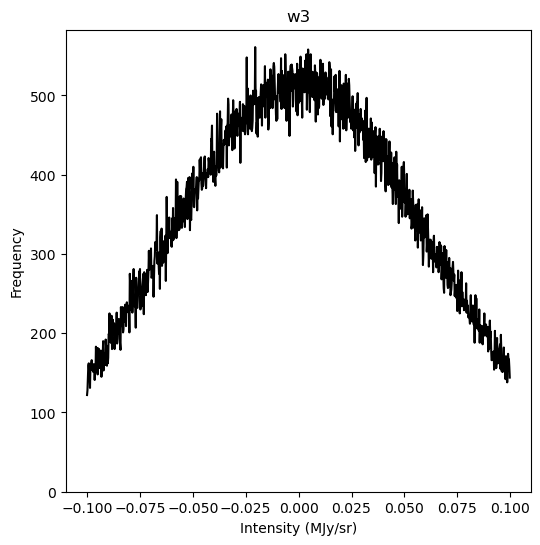

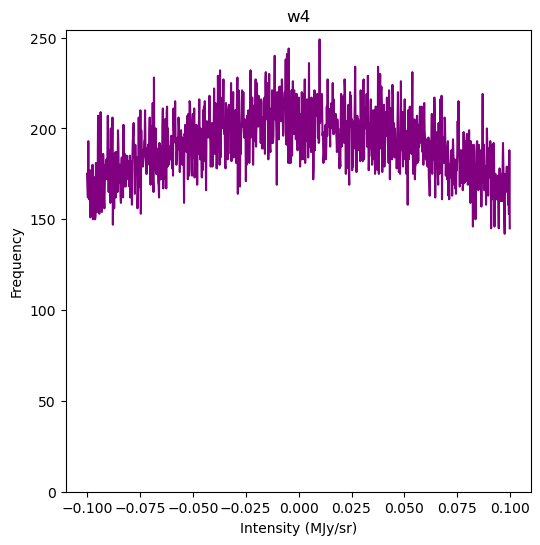

In [31]:
### make histograms ###
if histograms==True:
    i=0
    for instr in galx_instruments:
        color = colors[i]
        create_hist(instr, figx, figy, xlabel, ylabel, bins, color) # first input requires [0] to select first HDU in HDU List
        if i >= 7: # so the colors cycle back through (we have 8 colors)
            i=0
        else:
            i+=1

### should I modify create_hist to just take instr as the only argument? ###

# to change the range of the plots, see minclip and maxclip (variables in the above cell)

In [32]:
### get statistics ###
if statistics==True:
    for instr in galx_instruments:
        mask = np.ma.masked_invalid(galx_ser[instr].data).mask # must mask out np.NaN for statistics to work for irac
        masked_data = galx_ser[instr].data[~mask]
        calcMMM(masked_data,instr)
        print('---------------------------------------------')

### i should incorporate the mask into the calcMMM function and then just have it take one argument (instr) ###

# if (saveStats == True):
#     statsFile.close()

# note: these statistics take a very long time, so if you don't care about them you should comment out this cell

# Autogenerate Radial Profiles of the Particular Galaxy

In [33]:
import astropy.units as u
from astropy.wcs import WCS
from deproject import deproject, get_galaxy_specs

xlabel_rad = 'Radius (pc)'
ylabel_rad = 'Intensity (MJy/sr)'

def median(arr):
    arr.sort()
    length = len(arr)
    if length % 2 == 0:
        return ( arr[length // 2 - 1] + arr[length // 2] ) / 2
    else:
        return arr[length // 2]

def downsample(arr, n, med=False): # med is an optional parameter, if no value is assigned when calling the function, it assumes indicated value of False
    if n == 1:
        return arr
    result = []
    if med == True: # array should be flattened if this is the case; should I always flatten for consistency?
        arr = arr.flatten()
        for i in range(0, len(arr) + 1 - n, n):
            values = []
            for j in range(n):
                values.append(arr[i+j])
            result.append(median(values))
    else:
        for i in range(0, len(arr) + 1 - n, n):
            sum = 0
            for j in range(n):
                sum += arr[i+j] 
            result.append(sum / n)
    return result

def calc_r_pc(data):
    RA, DEC, POSANG, INCL, DIST = get_galaxy_specs(galaxy.upper()) # DIST [Mpc]
    wcs_galx = WCS(data.header)
    wcs_galx.sip = None
    deproj_img = deproject(center_coord=(RA*u.deg, DEC*u.deg), incl=INCL*u.deg, pa=POSANG*u.deg,
                               header=data.header, wcs=None, naxis=None, ra=None, dec=None,
                               return_offset=False)
    r_deg = deproj_img[0]
    r_pc = r_deg * (np.pi / 180) * (DIST * 1e6) # in pc
    return r_pc

def create_RadProfile(data, figx, figy, xlabel, ylabel, color, instr, r_pc, downsample_factor=1, downsample_med=False):
    f = plt.figure(figsize=(figx, figy))
    plt.scatter(downsample(r_pc, downsample_factor, med=downsample_med), downsample(data, downsample_factor, med=downsample_med), color=color)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(instr)
    # plt.grid()
    # if (saveFigs == True):
    #     saveFig(instr)

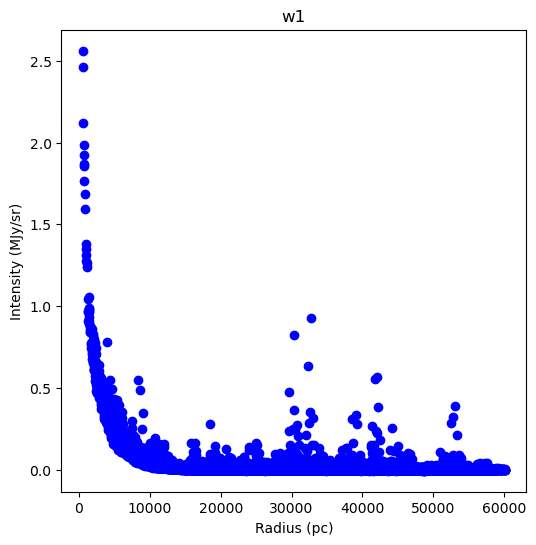

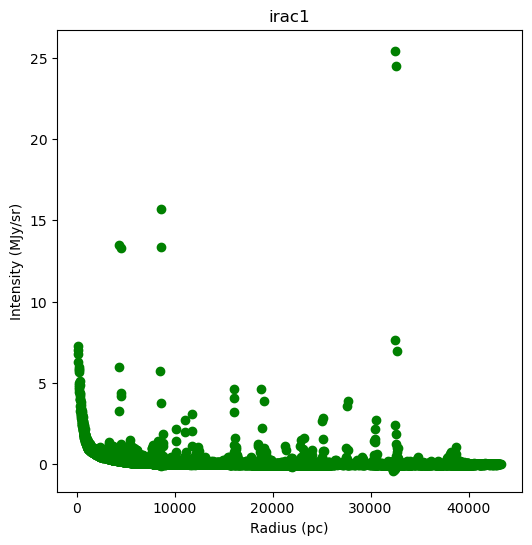

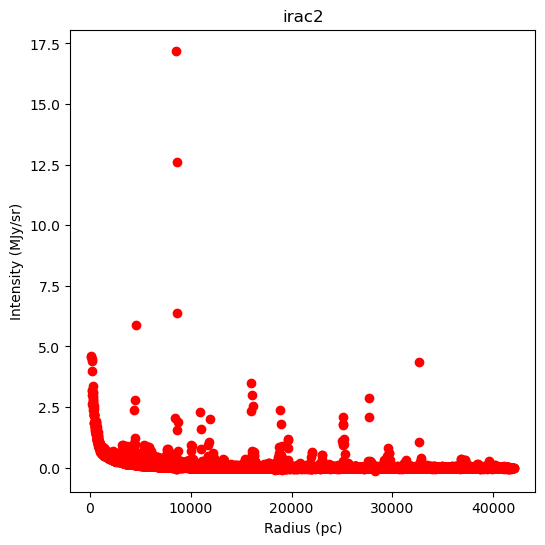

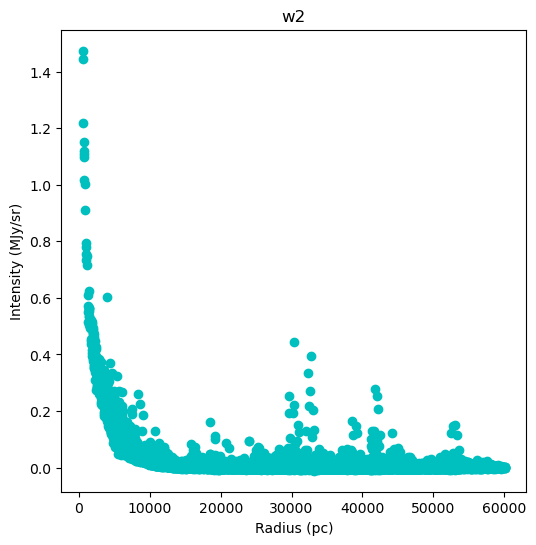

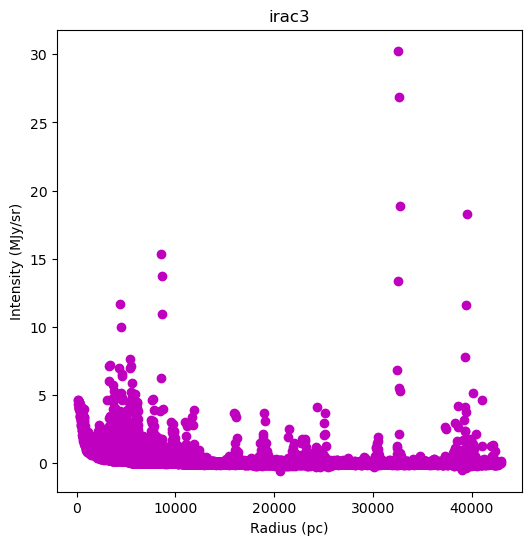

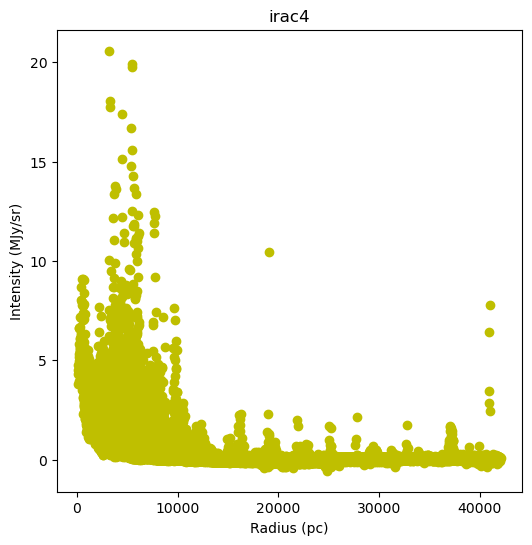

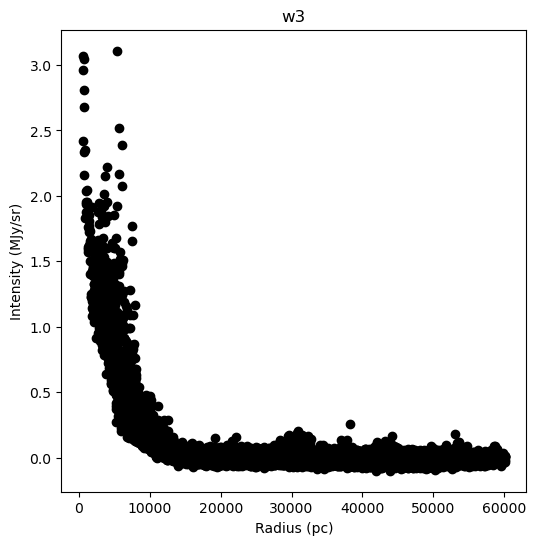

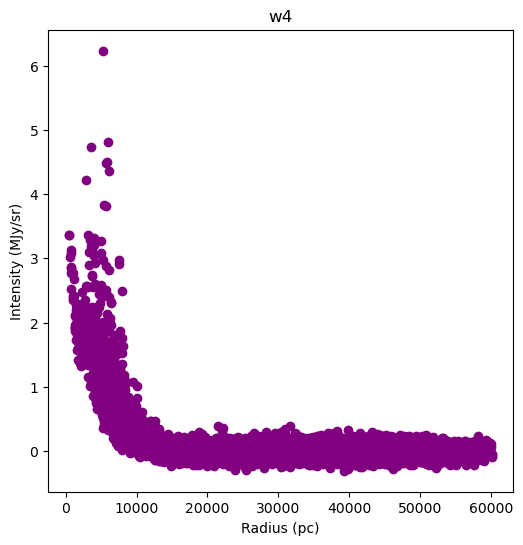

In [34]:
### generate radial profiles ###
if radial_profiles==True:
    i=0
    for instr in galx_instruments:
        color=colors[i]
        r_pc = calc_r_pc(galx_ser[instr])
        create_RadProfile(galx_ser[instr].data, figx, figy, xlabel_rad, ylabel_rad, color, instr, r_pc, downsample_factor=15, downsample_med=True)
        if i >= 7: # so the colors cycle back through (we have 8 colors)
            i=0
        else:
            i+=1

### should I modify create_RadProfile to take significantly fewer arguments? ###

# note: when plotting radial profiles for JWST, you'll get 2 warnings for each plot
    # it happens each time you open the WCS of a JWST image; it's nothing to worry about (the warnings aren't meaninful from the discussions I've seen), but they could supposedly be avoided by using gwcs instead of astropy

# for irac/wise, i tend to use downsample_factor=15; for jwst, i tend to use downsample_factor=30

# Generate Plots of Instruments Against One Another for the Particular Galaxy
Only making plots which are specified (because there a great many possible combinations)

In [35]:
combinations = [['w3', 'w4'], ['irac3', 'irac4'], ['w4', 'irac4']]#[['f300m','f360m']]   # specify which combinations of instruments you want to generate plots for

# for rescaling
from skimage.transform import rescale ### note: i've since put much more thought into rescaling and will probably modify its implementation in the below functions
from astropy.wcs.utils import proj_plane_pixel_scales
# for finding galaxy center
from astropy.stats import sigma_clipped_stats
from scipy.ndimage import label, center_of_mass

def center_galx(galx, rounding=True, display_galx=False, display_center = False): # galx should be hdu or np array, returns center as array of form (y_coord, x_coord); round makes it so that center is returned as integers; shouldn't try to simultaneously display galaxy and center
    # Calculate statistics of the image data
    mean, median, std = sigma_clipped_stats(galx.data, sigma=3.0) # not using median
    
    # Define a threshold to create a mask
    threshold = mean + (3 * std)
    mask = np.ma.masked_greater(galx.data, threshold, copy=True).mask # note: since for a numpy array array.data == array, I can treate HDU's and numpy arrays (which the rescaled galaxies are) the same
    
    # Label connected regions
    labeled_array, num_features = label(mask)
    
    # Find the largest connected component
    sizes = np.bincount(labeled_array.ravel()) # using flatten instead of ravel gives same answer
    sizes[0] = 0  # Ignore the background
    largest_label = sizes.argmax()

    center = center_of_mass(galx.data, labels=labeled_array, index=largest_label)
    result = np.asarray(center) # so that we can modify it if rounding==True
    
    if rounding == True:
        result[0] = round(result[0])
        result[1] = round(result[1])
        result = result.astype(int)
    
    if display_galx == True:
        galaxy_mask = labeled_array == largest_label
        ax = plt.imshow(galaxy_mask, cmap='gray', origin='lower')
        ax = plt.colorbar()
        result = ax
    
    if display_center == True:
        ax = plt.imshow(image_data, cmap='gray', origin='lower', vmin=-1e-4, vmax=3)
        ax = plt.colorbar()
        ax = plt.scatter(center[1], center[0], color='red', marker='+')
        result = ax
    
    return result

def galx_match(instr1, instr2, plot=False, savefig=False, title=None): # this version opens fits files; parameters should be strings
    # open fits files
    galx1 = galx_ser[instr1] # it might be better if I just pass the HDUs directly
    galx2 = galx_ser[instr2]
    
    # get WCS for each galaxy and rescale galx2
    wcs_galx1 = WCS(galx1.header)
    wcs_galx2 = WCS(galx2.header)
    pixel_scale_galx1 = proj_plane_pixel_scales(wcs_galx1)
    pixel_scale_galx2 = proj_plane_pixel_scales(wcs_galx2)
    galx2_rsc = rescale(galx2.data, pixel_scale_galx2 / pixel_scale_galx1, anti_aliasing=True)

    # create array (same shape as galx1) which we will 'paste' galx2_rsc into and find centers
    empty_galx1 = np.full_like(galx1.data, np.NaN)
    center_galx1 = center_galx(galx1)
    center_galx2_rsc = center_galx(galx2_rsc)

    # 'paste' galx2_rsc into array
        # depending on whether or not galx2_rsc is larger or smaller than galx1, we must handle 'paste' different
    shift = [-center_galx2_rsc[0] + center_galx1[0], -center_galx2_rsc[1] + center_galx1[1]] #'''fix'''
    if len(galx2_rsc) + shift[0] < len(galx1.data) and len(galx2_rsc[0]) + shift[1] < len(galx1.data[0]):
        for i in range(len(galx2_rsc)):
            for j in range(len(galx2_rsc[0])):
                if (i+shift[0])>0 and (j+shift[1])>0: # if statement necessary so that we're not plotting negative indices (which would otherwise occur when one of the components of shift is negative)
                    empty_galx1[i+shift[0]][j+shift[1]] = galx2_rsc[i][j]
    elif len(galx2_rsc) + shift[0] < len(galx1.data) and len(galx2_rsc[0]) + shift[1] > len(galx1.data[0]):
        for i in range(len(galx2_rsc)):
            for j in range(len(galx1.data[0])-shift[1]):
                if (i+shift[0])>0 and (j+shift[1])>0:
                    empty_galx1[i+shift[0]][j+shift[1]] = galx2_rsc[i][j]
    elif len(galx2_rsc) + shift[0] > len(galx1.data) and len(galx2_rsc[0]) + shift[1] < len(galx1.data[0]):
        for i in range(len(galx1.data)-shift[0]):
            for j in range(len(galx2_rsc[0])):
                if (i+shift[0])>0 and (j+shift[1])>0:
                    empty_galx1[i+shift[0]][j+shift[1]] = galx2_rsc[i][j]
    else:
        for i in range(len(galx1.data)-shift[0]):
            for j in range(len(galx1.data[0])-shift[1]):
                if (i+shift[0])>0 and (j+shift[1])>0: # if statement necessary so that we're not plotting negative indices 
                    empty_galx1[i+shift[0]][j+shift[1]] = galx2_rsc[i][j]

    if title == None:
        title = 'fix this'#galx2_filename.split('_')[0] + ' ' + galx2_filename.split('_')[1] + ' -> ' + galx1_filename.split('_')[0] + ' ' + galx1_filename.split('_')[1]
    if plot==True:
        ax = plt.subplot(projection=wcs_galx1)
        ax = plt.imshow(empty_galx1, origin='lower', vmin=-1e-4, vmax=3) # ''' shouldn't hard code vmin, vmax '''
        ax = plt.title('rescaled & shifted: ' + title) # .split method breaks string into a list strings (splits list at each occurence of parameter)
        ax = plt.grid()
        result = ax
    else:
        result = empty_galx1
    if savefig == True:
        plt.savefig('/Users/michaelhill/Desktop/PHANGS/Matched_Galaxies/' + title + '.png') # filepath will be different for you
    return result

def create_scatter(instr1, instr2, figx, figy, color, alpha=.5, downsample_factor=1, downsample_med=False, LoBF=False):
    f = plt.figure(figsize=(figx, figy))
    instr1_data = galx_ser[instr1].data
    instr2_data = galx_ser[instr2].data
    if instr1_data.shape != instr2_data.shape:
        instr2_data = galx_match(instr1, instr2) # matching instr2 to instr1 if they aren't already the same size
    plt.scatter(downsample(instr1_data, downsample_factor, med=downsample_med), downsample(instr2_data, downsample_factor, med=downsample_med), color=color, marker='.', alpha=alpha)
    plt.xlabel(instr1)
    plt.ylabel(instr2)
    plt.xlim(-.2, 1) # you may want to modify these (or maybe I should make these parameters for the function)
    plt.ylim(-.2, 1)
    plt.title(instr1 + ' vs ' + instr2)
    if LoBF == True:
        # scatter is only plotting points where both (x,y) are not nan, so we must remove all contrary values before calculating LoBF
        mask = ~np.isnan(instr1_data) & ~np.isnan(instr2_data)
        masked_instr1 = instr1_data[mask]
        masked_instr2 = instr2_data[mask]
        # make line of best fit
        m,b = np.polyfit(downsample(masked_instr1, downsample_factor, med=downsample_med), downsample(masked_instr2, downsample_factor, med=downsample_med), 1) # get slope and y-int for line of best fit; need to flatten masked_instr1 and masked_instr2 if I'm not applying downsample function
        # print(f'{instr1} vs {instr2} y-int: {b}') # in case you want to see how close it comes to going through 0
        plt.plot(masked_instr1, m*masked_instr1 + b, color='red' if color!='r' else 'b') # the last bit is saying that the color of the line will be red, unless the color of the plot is red (in which case it will be blue)
        plt.text(.3,-.17, f'y-intercept: {b}') # the first 2 parameters are the coordinates of the text
    # if (saveFigs == True):
    #     saveFig(instr)

def create_2dHist(instr1, instr2):
    f = plt.figure()#figsize=(figx, figy)) # can't set figsize because it gets messed up by colorbar
    instr1_data = galx_ser[instr1].data
    instr2_data = galx_ser[instr2].data
    if instr1_data.shape != instr2_data.shape:
        instr2_data = galx_match(instr1, instr2) # matching instr2 to instr1 if they aren't already the same size
    mask = ~np.isnan(instr1_data) & ~np.isnan(instr2_data) # have to remove all points (x,y) where either x is nan or y is nan
    masked_instr1 = instr1_data[mask]
    masked_instr2 = instr2_data[mask]
    plt.hist2d(masked_instr1.flatten(), masked_instr2.flatten(), bins=(3000, 3000), cmap=plt.cm.hsv, cmin=1, cmax=20) # should i make bins a parameter? ; setting cmin=1 seems to be the best move, but what to set cmax to seems arbitrary
    plt.xlabel(instr1 + ' Intensities (MJy/sr)')
    plt.ylabel(instr2 + ' Intensities (MJy/sr)')
    plt.xlim(-.2, 5) # you may want to modify these (or maybe I should make these parameters for the function)
    plt.ylim(-.2, 5)
    plt.title(instr1 + ' vs ' + instr2)
    plt.colorbar()
    # if (saveFigs == True):
    #     saveFig(instr)

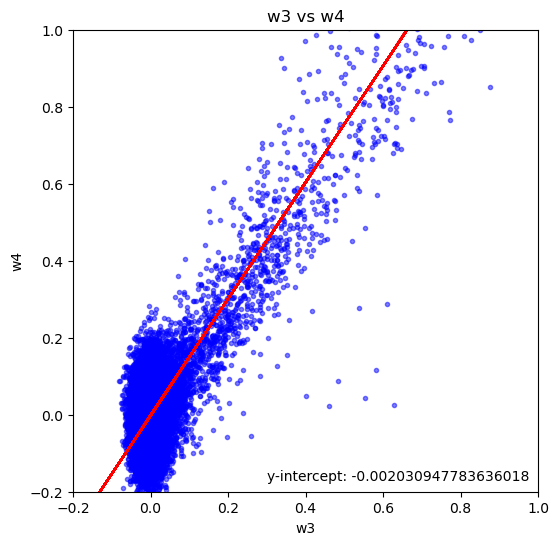

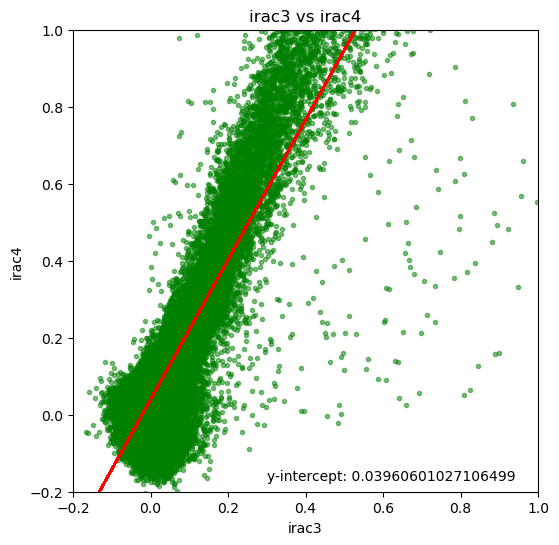

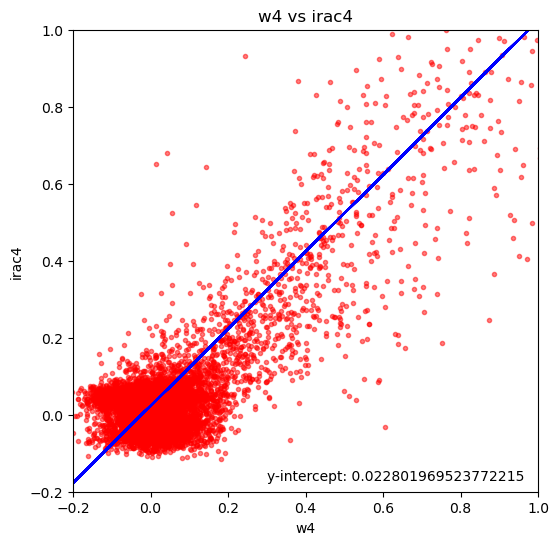

In [36]:
### generate scatter plots ###
if scatter_plots==True:
    i=0
    for pair in combinations:
        color=colors[i]
        create_scatter(pair[0], pair[1], figx, figy, color, downsample_factor=15, LoBF=True)
        if i > 7: # so the colors cycle back through (we have 8 colors)
            i=0
        else:
            i+=1

# for wise/irac, i tend to use axes limits of (-.2, 1) with a downsample_factor=15; for jwst, i tend to use axes limits of (-.2, 100) with downsample factor=3
# a similar effect to downsampling can be achieved by 'zooming out' (having larger axes limits)

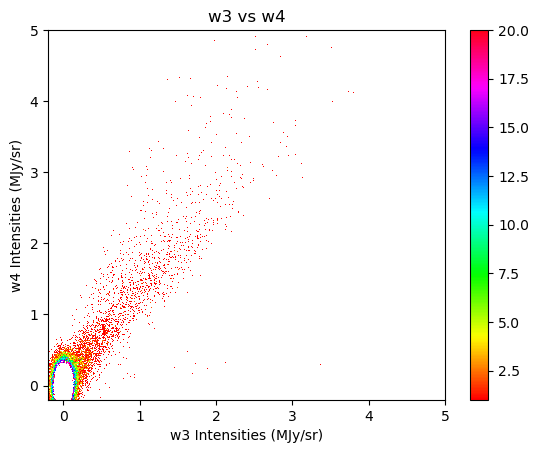

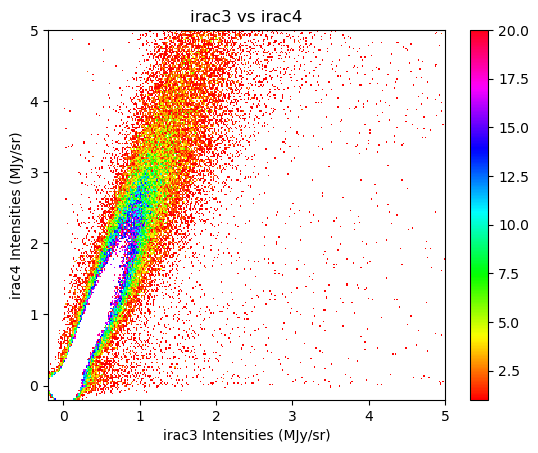

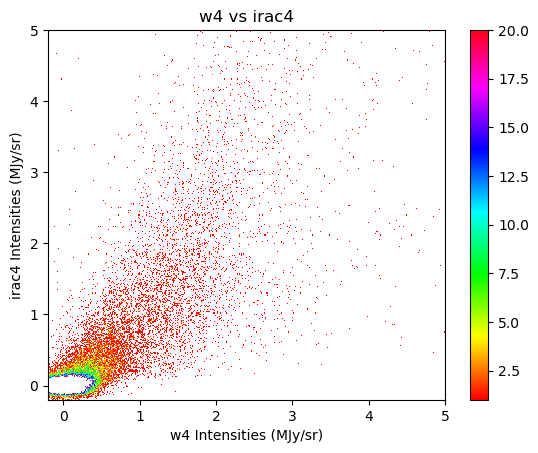

In [37]:
### generate 2d-histograms ###
if histograms_2d==True:
    for pair in combinations:
        create_2dHist(pair[0],pair[1])

# for wise/irac, i tend to use axes limits of (-.2, 5); for jwst, i tend to use axes limits of (-.2, 100)

In [38]:

###### right now I'm only calling galx_match if instruments are different shapes, but with some of the irac they have the same shape (i think) but different centers


''' think about this '''

' think about this '

In [39]:
# now do histograms or radial profiles on same axes (use plots already generated)

### organize everything ###

In [40]:
''' note to self: I've modified/fixed a lot of the functions used here; in their original forms (in other notebooks), they are likely still incorrect or work slightly differently '''

" note to self: I've modified/fixed a lot of the functions used here; in their original forms (in other notebooks), they are likely still incorrect or work slightly differently "